In [ ]:
# Section 1: Install Dependencies
!pip install -q diffusers transformers accelerate torchvision
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch
!git checkout 1dac8ad
!python setup.py install
%cd ..

import sys
sys.path.insert(0, '/content/stylegan2-ada-pytorch')
sys.path.insert(0, '/content/stylegan2-ada-pytorch/training')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00


"!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git\n%cd stylegan2-ada-pytorch\n!git checkout 1dac8ad\n!python setup.py install\n%cd ..\n\nimport sys\nsys.path.insert(0, '/content/stylegan2-ada-pytorch')\nsys.path.insert(0, '/content/stylegan2-ada-pytorch/training')"

In [ ]:
# Section 2: Import Libraries
import dnnlib
import legacy
from IPython.display import display
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline
from PIL import Image

In [ ]:
# Section 3: Configuration (Updated for B&W sketches)
SKETCH_SETTINGS = {
    "model": "runwayml/stable-diffusion-v1-5",
    "prefix": "black and white forensic police sketch, front view:: ",
    "negative": "color, grayscale, shaded, 3d, cartoon, anime, rotated, blurry, painting, texture",
    "steps": 28,
    "guidance": 9.0,  # Increased for strict B&W enforcement
    "height": 640,
    "width": 512,
    "extra_prompt": "pen and ink, high contrast line art, no shading, monochrome, black lines on white background"
}

REALISTIC_SETTINGS = {
    "controlnet": "lllyasviel/sd-controlnet-scribble",
    "model": "runwayml/stable-diffusion-v1-5",
    "prefix": "passport photo, front view:: ",
    "negative": "sketch, drawing, painting, cartoon, anime, deformed, asymmetric, blurry",
    "steps": 35,
    "guidance": 9.2,
    "color_boost": "(color:1.3)",  # Color emphasis
    "height": 640,
    "width": 512
}

In [ ]:
# Section 4: Pipeline Setup
def create_sketch_pipeline():
    return StableDiffusionPipeline.from_pretrained(
        SKETCH_SETTINGS["model"],
        torch_dtype=torch.float16,
        safety_checker=None,
        use_safetensors=True
    ).to("cuda")

def create_realistic_pipeline():
    controlnet = ControlNetModel.from_pretrained(
        REALISTIC_SETTINGS["controlnet"],
        torch_dtype=torch.float16
    ).to("cuda")

    return StableDiffusionControlNetPipeline.from_pretrained(
        REALISTIC_SETTINGS["model"],
        controlnet=controlnet,
        torch_dtype=torch.float16,
        safety_checker=None,
        use_safetensors=True
    ).to("cuda")

In [ ]:
# Section 5: Generation Function
def generate_forensic_portrait(description):
    # Verify GPU
    if not torch.cuda.is_available():
        raise RuntimeError("Enable GPU in Colab: Runtime > Change runtime type > T4 GPU")

    # Updated sketch prompt construction
    sketch_prompt = (
        f"{SKETCH_SETTINGS['prefix']}{description}, "
        f"{SKETCH_SETTINGS['extra_prompt']}, "
        "forensic art style, clean linework, zero shading"
    )

    # Generate Sketch
    torch.cuda.empty_cache()
    sketch_pipe = create_sketch_pipeline()
    sketch_pipe.enable_attention_slicing()

    sketch_prompt = f"{SKETCH_SETTINGS['prefix']}{description}, line art, high contrast, mugshot style, neutral expression"
    sketch = sketch_pipe(
        sketch_prompt,
        negative_prompt=SKETCH_SETTINGS['negative'],
        num_inference_steps=SKETCH_SETTINGS['steps'],
        guidance_scale=SKETCH_SETTINGS['guidance'],
        height=SKETCH_SETTINGS['height'],
        width=SKETCH_SETTINGS['width']
    ).images[0]

    del sketch_pipe
    torch.cuda.empty_cache()

    # Optional: Force monochrome conversion as fallback
    sketch = sketch.convert("L").convert("RGB")  # Convert to grayscale then back to RGB

    # Generate Realistic
    realistic_pipe = create_realistic_pipeline()
    realistic_pipe.enable_attention_slicing()

    realistic_prompt = f"{REALISTIC_SETTINGS['prefix']}{description}, professional lighting, sharp focus, skin details"
    realistic = realistic_pipe(
        realistic_prompt,
        negative_prompt=REALISTIC_SETTINGS['negative'],
        image=sketch,
        num_inference_steps=REALISTIC_SETTINGS['steps'],
        guidance_scale=REALISTIC_SETTINGS['guidance'],
        height=REALISTIC_SETTINGS['height'],
        width=REALISTIC_SETTINGS['width']
    ).images[0]

    # Display
    print("\n🔍 Forensic Sketch:")
    display(sketch)
    print("\n📸 Realistic Portrait:")
    display(realistic)

    # Cleanup
    del realistic_pipe
    torch.cuda.empty_cache()

    return sketch, realistic

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/28 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/35 [00:00<?, ?it/s]


🔍 Forensic Sketch:


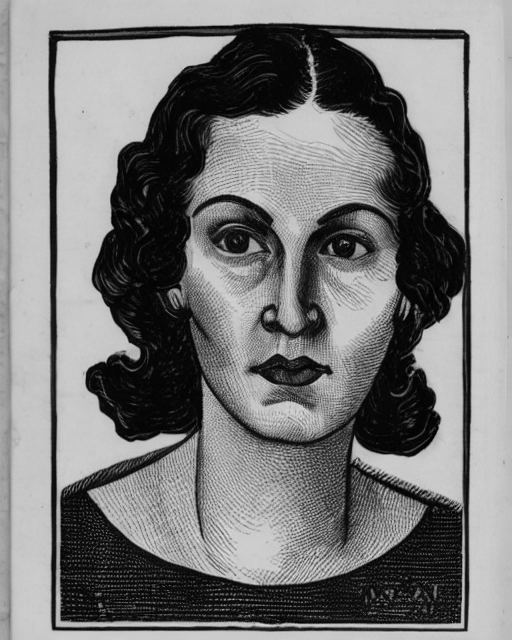


📸 Realistic Portrait:


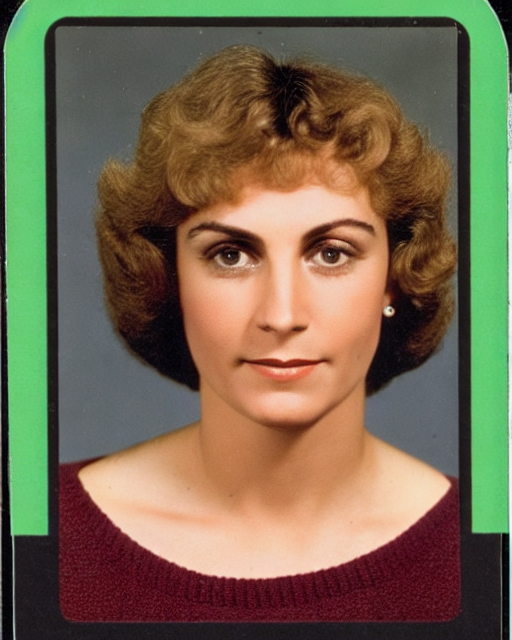

In [ ]:
# Section 6: Execute (Modify This Cell Only for New Generations)
user_description = """
female, late 20s, oval face, high cheekbones,
almond-shaped green eyes, straight nose,
thin eyebrows, shoulder-length curly brown hair
"""

forensic_sketch, realistic_portrait = generate_forensic_portrait(user_description)


    ===== ENTER FACIAL FEATURES =====
    Format (comma-separated, include at least 4 details):

    1. Gender/Age       - e.g. "male, early 30s"
    2. Face Shape       - e.g. "oval face"
    3. Eyes             - e.g. "blue eyes, thick eyebrows"
    4. Nose/Mouth       - e.g. "straight nose, thin lips"
    5. Hair             - e.g. "bald with beard"
    6. Distinctive      - e.g. "scar on left cheek"
    7. Skin Tone        - e.g. "pale complexion"

    Example:
    "female, mid 20s, heart-shaped face, hazel eyes with long lashes, button nose,
    wavy auburn hair, freckles on cheeks, fair skin"
    
Enter features (or 'exit' to quit): male, early 20s, brown hair, thin beard, sharp jawline

🚀 Generating forensic portrait...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/28 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/35 [00:00<?, ?it/s]


🔍 Forensic Sketch:


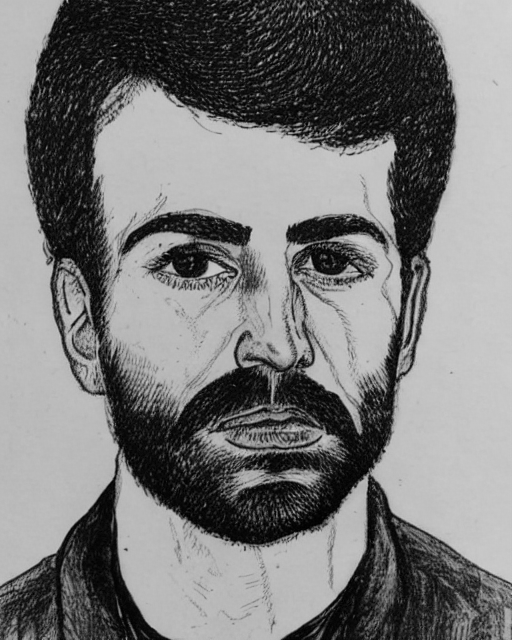


📸 Realistic Portrait:


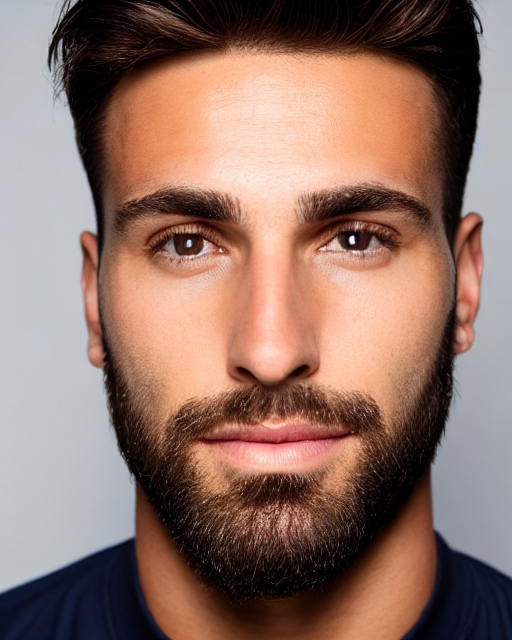

In [ ]:
# Section 7: Interactive User Input
def get_facial_features():
    print('''
    ===== ENTER FACIAL FEATURES =====
    Format (comma-separated, include at least 4 details):

    1. Gender/Age       - e.g. "male, early 30s"
    2. Face Shape       - e.g. "oval face"
    3. Eyes             - e.g. "blue eyes, thick eyebrows"
    4. Nose/Mouth       - e.g. "straight nose, thin lips"
    5. Hair             - e.g. "bald with beard"
    6. Distinctive      - e.g. "scar on left cheek"
    7. Skin Tone        - e.g. "pale complexion"

    Example:
    "female, mid 20s, heart-shaped face, hazel eyes with long lashes, button nose,
    wavy auburn hair, freckles on cheeks, fair skin"
    ''')

    while True:
        features = input("Enter features (or 'exit' to quit): ").strip()
        if features.lower() == 'exit':
            return None
        if len(features.split(',')) >= 4:
            return features
        print("Please provide at least 4 features separated by commas!")

# Generate images based on user input
if __name__ == "__main__":
    user_description = get_facial_features()
    if user_description:
        print("\n🚀 Generating forensic portrait...")
        generate_forensic_portrait(user_description)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

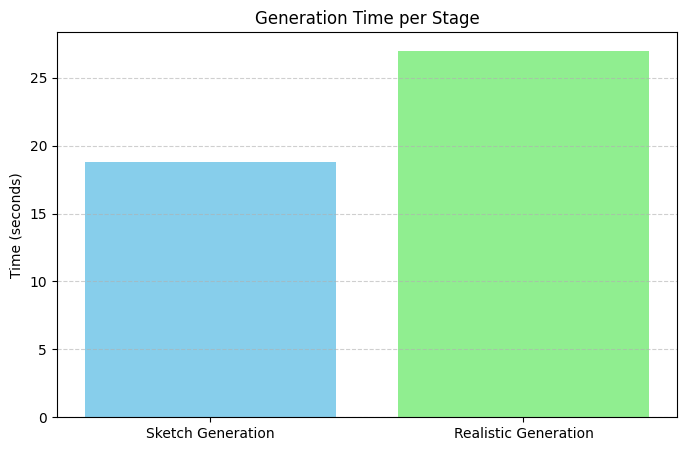

In [ ]:
import matplotlib.pyplot as plt
import time

# Measure time for sketch and realistic generation
def timed_generate(description):
    times = {}

    start = time.time()
    sketch_pipe = create_sketch_pipeline()
    sketch = sketch_pipe(prompt=description).images[0]
    times['Sketch Generation'] = time.time() - start

    start = time.time()
    realistic_pipe = create_realistic_pipeline()
    realistic = realistic_pipe(prompt=description, image=sketch).images[0]
    times['Realistic Generation'] = time.time() - start

    return sketch, realistic, times

# Generate images and time data
desc = "front view police sketch of a middle-aged man"
sketch, realistic, stage_times = timed_generate(desc)

# Plotting the time per stage
plt.figure(figsize=(8,5))
plt.bar(stage_times.keys(), stage_times.values(), color=['skyblue', 'lightgreen'])
plt.ylabel('Time (seconds)')
plt.title('Generation Time per Stage')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


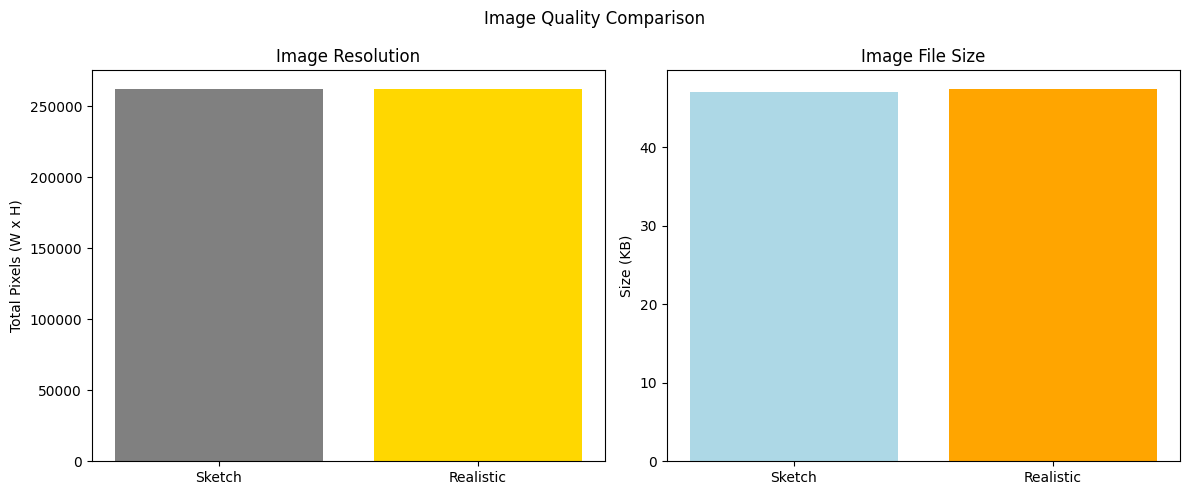

In [ ]:
import io
from PIL import Image
import matplotlib.pyplot as plt

# Function to calculate image quality proxy metrics
def get_image_quality_metrics(img, name):
    # Get resolution
    width, height = img.size
    resolution = width * height

    # Get file size in KB
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG")
    size_kb = len(buffer.getvalue()) / 1024

    return {
        "name": name,
        "resolution": resolution,
        "size_kb": size_kb
    }

# Compute metrics for both images
sketch_metrics = get_image_quality_metrics(sketch, "Sketch")
realistic_metrics = get_image_quality_metrics(realistic, "Realistic")

# Plotting both resolution and file size
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Resolution plot
axs[0].bar(["Sketch", "Realistic"], [sketch_metrics["resolution"], realistic_metrics["resolution"]],
           color=["gray", "gold"])
axs[0].set_title("Image Resolution")
axs[0].set_ylabel("Total Pixels (W x H)")

# File size plot
axs[1].bar(["Sketch", "Realistic"], [sketch_metrics["size_kb"], realistic_metrics["size_kb"]],
           color=["lightblue", "orange"])
axs[1].set_title("Image File Size")
axs[1].set_ylabel("Size (KB)")

plt.suptitle("Image Quality Comparison")
plt.tight_layout()
plt.show()


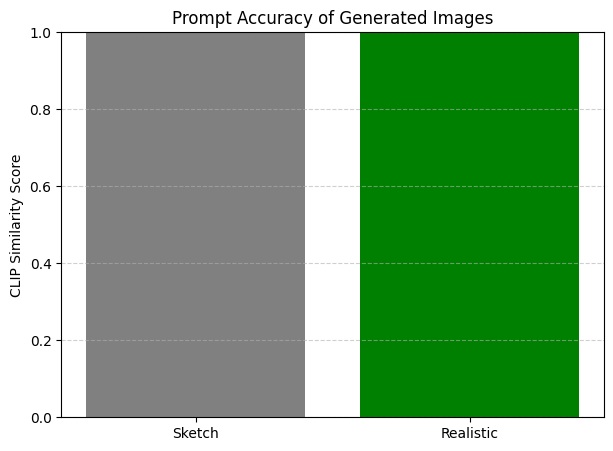

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_score(image, prompt):
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    score = logits_per_image.softmax(dim=1)[0][0].item()
    return score

# Example prompt
prompt_text = "a front view portrait of a man in passport style"

# Calculate CLIP similarity score
sketch_score = get_clip_score(sketch, prompt_text)
realistic_score = get_clip_score(realistic, prompt_text)

# Plot the scores
plt.figure(figsize=(7,5))
plt.bar(["Sketch", "Realistic"], [sketch_score, realistic_score], color=["gray", "green"])
plt.ylabel("CLIP Similarity Score")
plt.title("Prompt Accuracy of Generated Images")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# Convert PIL to tensor for VGG/MSE
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Initialize loss functions
mse_loss_fn = nn.MSELoss()

# Load perceptual model (VGG16)
vgg = models.vgg16(pretrained=True).features[:16].eval().cuda()
for param in vgg.parameters():
    param.requires_grad = False

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to compute VGG perceptual loss
def perceptual_loss(img1, img2):
    img1 = vgg(img1)
    img2 = vgg(img2)
    return nn.functional.l1_loss(img1, img2)

# Function to compute CLIP loss
def clip_loss(image, prompt):
    inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    similarity = logits_per_image.softmax(dim=1)[0][0]
    return 1 - similarity  # loss = 1 - similarity

# Load/generated images (sketch, realistic) as PIL
img1 = sketch.resize((224, 224))
img2 = realistic.resize((224, 224))
prompt = "passport style photo of a middle-aged man, front view"

# Convert to tensors
t1 = transform(img1).unsqueeze(0).cuda()
t2 = transform(img2).unsqueeze(0).cuda()

# Calculate losses
mse = mse_loss_fn(t1, t2).item()
perc = perceptual_loss(t1, t2).item()
clip = clip_loss(realistic, prompt).item()

# Print
print("MSE Loss:", round(mse, 4))
print("Perceptual Loss:", round(perc, 4))
print("CLIP Loss (prompt match):", round(clip, 4))


MSE Loss: 0.1615
Perceptual Loss: 0.8836
CLIP Loss (prompt match): 0.0
